# Mortality CSV ICL Results

This notebook mirrors `plot_results_sim.ipynb` and focuses on the `mortality_csv` experiment.

It loads prediction pickles from `outputs/` and plots performance across:
- **context length** (`icl_num_examples`)
- **serialization strategy** (`Dropped`, `Indicator`, `Indicator + Inst.`)

Strategy mapping:
- `explicit_missingness=False` -> `Dropped`
- `explicit_missingness=True, include_cot_prompt=False` -> `Indicator`
- `explicit_missingness=True, include_cot_prompt=True` -> `Indicator + Inst.`


In [1]:
from pathlib import Path
import pickle
import math
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, log_loss

sns.set_style("whitegrid")
pd.set_option("display.max_columns", 200)

ROOT = Path(".").resolve()
PREDICTIONS_DIR = ROOT / "outputs"
PLOTS_DIR = ROOT / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
TASK = "mortality_csv"

print("Root:", ROOT)
print("Predictions dir:", PREDICTIONS_DIR)


Root: /home/yk3043@mc.cumc.columbia.edu/EHR-missingness
Predictions dir: /home/yk3043@mc.cumc.columbia.edu/EHR-missingness/outputs


In [2]:
def safe_load_pickle(path: Path):
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception as exc:
        print(f"Failed to load {path.name}: {exc}")
        return None


def parse_icl_filename(path: Path, task: str):
    name = path.name
    prefix = f"predictions_{task}_"
    if not (name.startswith(prefix) and name.endswith(".pkl")):
        return None

    stem = name[:-4]  # remove .pkl
    suffix = stem[len(prefix):]
    tokens = suffix.split("_")

    # Expected endings:
    # 1) ..._<exp_missing>_<labs_only>_<include_cot>_iclK_seedS
    # 2) ..._<exp_missing>_<labs_only>_<include_cot>_iclK_<icl_sampling>_seedS
    # 3) either of the above plus optional _cohort-<name>
    # 4) either of the above plus optional _testN suffix (e.g., _seed1_test5)
    test_token = None
    if len(tokens) >= 1 and tokens[-1].startswith("test"):
        test_token = tokens[-1]
        tokens = tokens[:-1]

    if len(tokens) < 6:
        return None

    seed_token = tokens[-1]
    if not seed_token.startswith("seed"):
        return None

    tokens_no_seed = tokens[:-1]

    cohort = None
    if len(tokens_no_seed) >= 1 and tokens_no_seed[-1].startswith("cohort-"):
        cohort = tokens_no_seed[-1].replace("cohort-", "").strip().lower() or None
        tokens_no_seed = tokens_no_seed[:-1]

    if len(tokens_no_seed) < 5:
        return None

    # Optional icl sampling token (e.g., random/stratified/balanced)
    maybe_sampling = tokens_no_seed[-1].strip().lower()
    if len(tokens_no_seed) >= 6 and not tokens_no_seed[-1].startswith("icl"):
        icl_sampling_strategy = maybe_sampling
        icl_token = tokens_no_seed[-2]
        include_cot_token = tokens_no_seed[-3]
        labs_only_token = tokens_no_seed[-4]
        exp_missing_token = tokens_no_seed[-5]
        model = "_".join(tokens_no_seed[:-5])
    else:
        icl_sampling_strategy = None
        icl_token = tokens_no_seed[-1]
        include_cot_token = tokens_no_seed[-2]
        labs_only_token = tokens_no_seed[-3]
        exp_missing_token = tokens_no_seed[-4]
        model = "_".join(tokens_no_seed[:-4])

    if not model:
        return None
    if exp_missing_token not in {"True", "False"}:
        return None
    if labs_only_token not in {"True", "False"}:
        return None
    if include_cot_token not in {"True", "False"}:
        return None
    if not icl_token.startswith("icl"):
        return None

    try:
        icl_num = int(icl_token.replace("icl", ""))
        seed = int(seed_token.replace("seed", ""))
        test_num = int(test_token.replace("test", "")) if test_token else None
    except ValueError:
        return None

    # Keep two fields for icl0 runs:
    # - icl_sampling_strategy: always "none" for zero-shot compatibility in plots
    # - zero_shot_variant: distinguishes plain icl0 ("standard") vs icl0_baseline ("baseline")
    zero_shot_variant = None
    if icl_num == 0:
        raw_zero_shot_token = (icl_sampling_strategy or "").strip().lower()
        if raw_zero_shot_token in {"baseline", "provide_prevalence"}:
            zero_shot_variant = "baseline"
        elif raw_zero_shot_token in {"", "none"}:
            zero_shot_variant = "standard"
        else:
            zero_shot_variant = raw_zero_shot_token
        icl_sampling_strategy = "none"
    elif not icl_sampling_strategy:
        # Backward-compatible default: historical icl>0 files with no strategy token
        # were generated with random selection.
        icl_sampling_strategy = "random"

    return {
        "task": task,
        "model": model,
        "explicit_missingness": exp_missing_token == "True",
        "labs_only": labs_only_token == "True",
        "include_cot_prompt": include_cot_token == "True",
        "icl_num_examples": icl_num,
        "icl_sampling_strategy": icl_sampling_strategy,
        "zero_shot_variant": zero_shot_variant,
        "cohort": cohort,
        "seed": seed,
        "test_num_samples": test_num,
        "path": path,
    }


def strategy_label(explicit_missingness: bool, include_cot_prompt: bool):
    if not explicit_missingness:
        return "Dropped"
    if explicit_missingness and not include_cot_prompt:
        return "Indicator"
    return "Indicator + Inst."


def is_prob(value):
    try:
        x = float(value)
    except Exception:
        return False
    return math.isfinite(x) and 0.0 <= x <= 1.0


def expected_calibration_error(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true).astype(float)
    y_prob = np.asarray(y_prob).astype(float)
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    n = len(y_true)

    for b in range(n_bins):
        mask = bin_ids == b
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / n) * abs(acc - conf)

    return float(ece)


def compute_binary_metrics(y_true, y_prob, eps=1e-6):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_prob = np.clip(y_prob, eps, 1 - eps)

    if len(np.unique(y_true)) < 2:
        auroc = np.nan
    else:
        auroc = float(roc_auc_score(y_true, y_prob))

    return {
        "n": int(len(y_true)),
        "auroc": auroc,
        "log_loss": float(log_loss(y_true, y_prob)),
        "ece": expected_calibration_error(y_true, y_prob, n_bins=10),
    }


In [3]:
rows = []
for path in sorted(PREDICTIONS_DIR.glob(f"predictions_{TASK}_*_icl*.pkl")):
    meta = parse_icl_filename(path, TASK)
    if meta is None:
        continue

    pred_dict = safe_load_pickle(path)
    if not isinstance(pred_dict, dict):
        continue

    y_true = []
    y_prob = []
    for _, item in pred_dict.items():
        if not isinstance(item, dict):
            continue
        label = item.get("label")
        if label is None:
            continue

        sample_preds = item.get("prediction_samples")
        valid_sample_preds = []
        if isinstance(sample_preds, list):
            valid_sample_preds = [float(p) for p in sample_preds if is_prob(p)]

        if valid_sample_preds:
            pred = float(np.mean(valid_sample_preds))
        else:
            # Backward-compatible fallback for files without prediction_samples
            single_pred = item.get("prediction")
            if not is_prob(single_pred):
                continue
            pred = float(single_pred)

        y_true.append(int(bool(label)))
        y_prob.append(pred)

    if len(y_true) == 0:
        continue

    metrics = compute_binary_metrics(y_true, y_prob)
    rows.append({
        **meta,
        **metrics,
        "serialization_strategy": strategy_label(
            meta["explicit_missingness"],
            meta["include_cot_prompt"],
        ),
    })

results_df = pd.DataFrame(rows)
if results_df.empty:
    raise RuntimeError("No mortality_csv prediction files found. Check outputs/ and filename pattern.")


In [4]:
# # Color by model, linestyle by serialization strategy;
# # split rows by ICL sample selection strategy (e.g., random vs balanced).
# strategy_order = ["Dropped", "Indicator", "Indicator + Inst."]
# strategy_linestyles = {
#     "Dropped": "solid",
#     "Indicator": "dashed",
#     "Indicator + Inst.": "dotted",
# }

# icl_sampling_order = ["stratified", "balanced"]
# available_sampling = [
#     s for s in icl_sampling_order
#     if s in set(results_df["icl_sampling_strategy"].astype(str).str.lower())
# ]
# if not available_sampling:
#     raise RuntimeError("No random/balanced ICL sampling runs found in results_df.")

# model_order = sorted(results_df["model"].unique())
# n_models = len(model_order)
# model_palette = sns.color_palette("colorblind", n_colors=n_models)
# model_color_dict = dict(zip(model_order, model_palette))

# plot_df = results_df.copy()
# plot_df["icl_sampling_strategy"] = plot_df["icl_sampling_strategy"].astype(str).str.lower()

# # Keep selected ICL sampling strategies and also include zero-shot (icl=0, strategy=none).
# icl_df = plot_df[
#     (plot_df["icl_num_examples"] > 0)
#     & (plot_df["icl_sampling_strategy"].isin(available_sampling))
# ].copy()
# zero_shot_df = plot_df[
#     (plot_df["icl_num_examples"] == 0)
#     & (plot_df["icl_sampling_strategy"] == "none")
# ].copy()

# # Duplicate zero-shot rows into each sampling panel so x=0 baseline appears in both.
# if not zero_shot_df.empty:
#     zero_shot_panel_rows = []
#     for sample_strategy in available_sampling:
#         z = zero_shot_df.copy()
#         z["icl_sampling_strategy"] = sample_strategy
#         zero_shot_panel_rows.append(z)
#     zero_shot_panel_df = pd.concat(zero_shot_panel_rows, ignore_index=True)
#     plot_df = pd.concat([icl_df, zero_shot_panel_df], ignore_index=True)
# else:
#     plot_df = icl_df

# plot_df["serialization_strategy"] = pd.Categorical(
#     plot_df["serialization_strategy"],
#     categories=strategy_order,
#     ordered=True,
# )
# plot_df["model"] = pd.Categorical(
#     plot_df["model"],
#     categories=model_order,
#     ordered=True,
# )

# metrics = [("auroc", "AUROC", False), ("log_loss", "Log Loss", True), ("ece", "ECE", True)]
# fig, axes = plt.subplots(
#     len(available_sampling),
#     len(metrics),
#     figsize=(16, 4.8 * len(available_sampling)),
#     sharex=True,
# )

# if len(available_sampling) == 1:
#     axes = np.array([axes])

# for row_idx, sample_strategy in enumerate(available_sampling):
#     row_df = plot_df[plot_df["icl_sampling_strategy"] == sample_strategy]

#     for col_idx, (metric_col, title, lower_is_better) in enumerate(metrics):
#         ax = axes[row_idx, col_idx]

#         # For each model and serialization strategy, plot a line with desired style/color.
#         for model in model_order:
#             for strategy in strategy_order:
#                 data = row_df[
#                     (row_df["model"] == model)
#                     & (row_df["serialization_strategy"] == strategy)
#                 ]
#                 if data.empty:
#                     continue

#                 grouped = (
#                     data.groupby("icl_num_examples", as_index=False)[metric_col]
#                     .agg(["mean", "std"])
#                     .reset_index()
#                 )
#                 x = grouped["icl_num_examples"]
#                 y = grouped["mean"]
#                 yerr = grouped["std"].fillna(0.0)
#                 if len(x) == 0:
#                     continue

#                 label = f"{model} / {strategy}"
#                 ax.errorbar(
#                     x,
#                     y,
#                     yerr=yerr,
#                     label=label,
#                     color=model_color_dict[model],
#                     linestyle=strategy_linestyles[strategy],
#                     marker="o",
#                     capsize=3,
#                     alpha=0.9,
#                 )

#         ax.set_title(f"{title} ({sample_strategy})")
#         ax.set_xlabel("ICL examples (context length)")
#         ax.set_ylabel(title)
#         if lower_is_better:
#             ax.text(0.02, 0.02, "lower is better", transform=ax.transAxes, fontsize=8, alpha=0.75)

# # Single legend for cleaner layout.
# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=8, title="Model / Serialization", loc="upper right")
# plt.tight_layout(rect=(0, 0, 0.9, 1))

# save_path = PLOTS_DIR / "mortality_csv_context_vs_serialization_by_icl_sampling.pdf"
# plt.savefig(save_path, bbox_inches="tight")
# plt.show()
# print("Saved:", save_path)


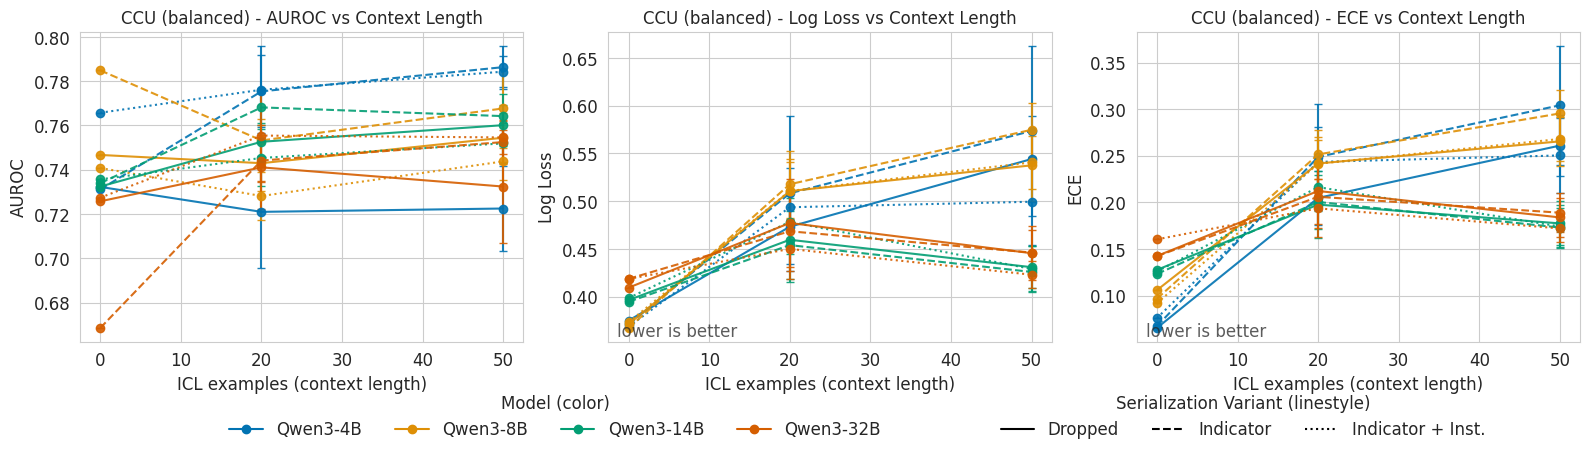

Saved: /home/yk3043@mc.cumc.columbia.edu/EHR-missingness/plots/mortality_csv_context_vs_serialization_by_cohort_balanced.pdf

Log loss side-by-side comparison by ICL sampling strategy:


/tmp/ipykernel_2107285/1551313492.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(
/tmp/ipykernel_2107285/1551313492.py:270: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(
/tmp/ipykernel_2107285/1551313492.py:286: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(
/tmp/ipykernel_2107285/1551313492.py:297: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify

cohort_for_plot                                                          log_loss_ccu  \
model     serialization_strategy icl_sampling_strategy icl_num_examples                 
Qwen3-4B  Dropped                balanced              0                     0.374992   
                                                       20                    0.473227   
                                                       50                    0.544053   
          Indicator              balanced              0                     0.371054   
                                                       20                    0.508158   
                                                       50                    0.573480   
          Indicator + Inst.      balanced              0                     0.368473   
                                                       20                    0.493602   
                                                       50                    0.499374   
Qwen3-8B  Dropped                balanced              0                     0.371178   
                                                       20                    0.510480   
                                                       50                    0.537473   
          Indicator              balanced              0                     0.367262   
                                                       20                    0.517677   
                                                       50                    0.574692   
          Indicator + Inst.      balanced              0                     0.373246   
                                                       20                    0.510630   
                                                       50                    0.540565   
Qwen3-14B Dropped                balanced              0                     0.396465   
                                                       20                    0.459559   
                                                       50                    0.430876   
          Indicator              balanced              0                     0.394604   
                                                       20                    0.453965   
                                                       50                    0.425892   
          Indicator + Inst.      balanced              0                     0.398632   
                                                       20                    0.478327   
                                                       50                    0.429014   
Qwen3-32B Dropped                balanced              0                     0.409433   
                                                       20                    0.477135   
                                                       50                    0.445519   
          Indicator              balanced              0                     0.418700   
                                                       20                    0.468458   
                                                       50                    0.446179   
          Indicator + Inst.      balanced              0                     0.418524   
                                                       20                    0.449983   
                                                       50                    0.423004   

cohort_for_plot                                                          log_loss_std_ccu  \
model     serialization_strategy icl_sampling_strategy icl_num_examples                     
Qwen3-4B  Dropped                balanced              0                              NaN   
                                                       20                        0.038955   
                                                       50                        0.044756   
          Indicator              balanced              0                              NaN   
                                                       20  

Saved: /home/yk3043@mc.cumc.columbia.edu/EHR-missingness/plots/mortality_csv_log_loss_by_cohort_side_by_side_balanced.csv


In [5]:
# Plot by cohort (CCU/MICU) with the same style as the overall plot,
# with selectable ICL sampling strategy.
strategy_order = ["Dropped", "Indicator", "Indicator + Inst."]
strategy_linestyles = {
    "Dropped": "solid",
    "Indicator": "dashed",
    "Indicator + Inst.": "dotted",
}

if "results_df" in globals() and isinstance(results_df, pd.DataFrame) and not results_df.empty:
    base_df = results_df.copy()
elif "results_df_gemini_jsonl" in globals() and isinstance(results_df_gemini_jsonl, pd.DataFrame) and not results_df_gemini_jsonl.empty:
    base_df = results_df_gemini_jsonl.copy()
else:
    raise RuntimeError(
        "No results dataframe found. Run the PKL loading cell (results_df) or Gemini JSONL cell (results_df_gemini_jsonl) first."
    )

def _model_sort_key(model_name: str):
    s = str(model_name)
    s_lower = s.lower()

    # Prefer numeric size ordering when present (e.g., 1.7B, 4B, 14B, 32B).
    size_match = re.search(r"(\d+(?:\.\d+)?)\s*([bm])\b", s_lower)
    if size_match:
        size_val = float(size_match.group(1))
        unit = size_match.group(2)
        # Convert to "billions" for comparable ordering.
        size_in_b = size_val if unit == "b" else size_val / 1000.0
    else:
        size_in_b = float("inf")

    # Group by family-ish prefix so mixed families still look consistent.
    family = s_lower.split("/")[0] if "/" in s_lower else s_lower.split("-")[0]
    return (family, size_in_b, s_lower)


model_order = sorted(base_df["model"].astype(str).unique(), key=_model_sort_key)
n_models = len(model_order)
model_palette = sns.color_palette("colorblind", n_colors=n_models)
model_color_dict = dict(zip(model_order, model_palette))

from matplotlib.lines import Line2D

FONT_SIZE = 12

cohort_order = ["ccu"]
selected_icl_sampling = ["balanced"]  # e.g., ["balanced"] or ["stratified", "balanced"]
include_zero_shot_baseline = True
# zero-shot overlay choice: "any", "standard", "baseline"
# Note: with current save logic, provide_prevalence="baseline" is written as icl0_baseline.
selected_zero_shot_variant = "baseline"

plot_df = base_df.copy()
plot_df["icl_sampling_strategy"] = plot_df["icl_sampling_strategy"].astype(str).str.lower()
selected_icl_sampling = [s.lower() for s in selected_icl_sampling]
selected_zero_shot_variant = str(selected_zero_shot_variant).strip().lower()

# Ensure zero_shot_variant exists (from parser). Fallback only if older dataframe lacks it.
if "zero_shot_variant" not in plot_df.columns:
    path_str = plot_df["path"].astype(str).str.lower() if "path" in plot_df.columns else pd.Series([""] * len(plot_df))
    plot_df["zero_shot_variant"] = "other"
    plot_df.loc[
        path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True),
        "zero_shot_variant",
    ] = "baseline"
    plot_df.loc[
        (~path_str.str.contains(r"_icl0_baseline(_|\\.)", regex=True))
        & path_str.str.contains(r"_icl0(_|\\.)", regex=True),
        "zero_shot_variant",
    ] = "standard"

# Prefer an existing cohort column; otherwise infer from available metadata.
if "cohort" in plot_df.columns:
    plot_df["cohort_for_plot"] = plot_df["cohort"].astype(str).str.lower()
elif "task" in plot_df.columns:
    plot_df["cohort_for_plot"] = (
        plot_df["task"]
        .astype(str)
        .str.extract(r"(ccu|micu)", expand=False)
        .str.lower()
    )
elif "path" in plot_df.columns:
    plot_df["cohort_for_plot"] = (
        plot_df["path"]
        .astype(str)
        .str.extract(r"(?:^|[^a-zA-Z])(ccu|micu)(?:[^a-zA-Z]|$)", expand=False)
        .str.lower()
    )
else:
    plot_df["cohort_for_plot"] = np.nan

plot_df = plot_df[plot_df["cohort_for_plot"].isin(cohort_order)].copy()

# Keep chosen ICL sampling strategies.
icl_df = plot_df[
    (plot_df["icl_num_examples"] > 0)
    & (plot_df["icl_sampling_strategy"].isin(selected_icl_sampling))
].copy()

# Optionally add zero-shot baseline (icl=0, strategy=none) into each selected panel.
if include_zero_shot_baseline:
    zero_shot_df = plot_df[
        (plot_df["icl_num_examples"] == 0)
        & (plot_df["icl_sampling_strategy"] == "none")
    ].copy()

    # Backward-compatible alias: "provide_prevalence" -> "baseline"
    if selected_zero_shot_variant == "provide_prevalence":
        selected_zero_shot_variant = "baseline"

    if selected_zero_shot_variant in {"standard", "baseline"}:
        zero_shot_df = zero_shot_df[
            zero_shot_df["zero_shot_variant"] == selected_zero_shot_variant
        ].copy()

    if not zero_shot_df.empty:
        zero_shot_panel_rows = []
        for sample_strategy in selected_icl_sampling:
            z = zero_shot_df.copy()
            z["icl_sampling_strategy"] = sample_strategy
            zero_shot_panel_rows.append(z)
        icl_df = pd.concat([icl_df] + zero_shot_panel_rows, ignore_index=True)

plot_df = icl_df.copy()
plot_df["serialization_strategy"] = pd.Categorical(
    plot_df["serialization_strategy"],
    categories=strategy_order,
    ordered=True,
)
plot_df["model"] = pd.Categorical(
    plot_df["model"],
    categories=model_order,
    ordered=True,
)

if plot_df.empty:
    print("No cohort rows found after ICL sampling strategy filter.")
    print(f"zero_shot_variant filter: {selected_zero_shot_variant}")
    if "zero_shot_variant" in base_df.columns:
        print("available zero_shot_variant values:", sorted(base_df["zero_shot_variant"].dropna().astype(str).unique().tolist()))
else:
    sampling_to_plot = [
        s for s in selected_icl_sampling
        if s in set(plot_df["icl_sampling_strategy"].astype(str).str.lower())
    ]
    if not sampling_to_plot:
        raise RuntimeError("No matching ICL sampling strategies found in cohort-filtered data.")

    metrics = [("auroc", "AUROC", False), ("log_loss", "Log Loss", True), ("ece", "ECE", True)]
    n_rows = len(cohort_order) * len(sampling_to_plot)
    fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4.5 * n_rows), sharex=True)

    if n_rows == 1:
        axes = np.array([axes])

    row_ptr = 0
    for cohort in cohort_order:
        cohort_df = plot_df[plot_df["cohort_for_plot"] == cohort]

        for sample_strategy in sampling_to_plot:
            panel_df = cohort_df[cohort_df["icl_sampling_strategy"] == sample_strategy]

            for col_idx, (metric_col, title, lower_is_better) in enumerate(metrics):
                ax = axes[row_ptr, col_idx]

                for model in model_order:
                    for strategy in strategy_order:
                        data = panel_df[
                            (panel_df["model"] == model)
                            & (panel_df["serialization_strategy"] == strategy)
                        ]
                        if data.empty:
                            continue

                        means = (
                            data
                            .groupby("icl_num_examples", as_index=False)[metric_col]
                            .mean()
                        )
                        stds = (
                            data
                            .groupby("icl_num_examples", as_index=False)[metric_col]
                            .std()
                        )
                        x = means["icl_num_examples"]
                        y = means[metric_col]
                        yerr = stds[metric_col].fillna(0.0)
                        if len(x) == 0:
                            continue

                        ax.errorbar(
                            x,
                            y,
                            yerr=yerr,
                            color=model_color_dict[model],
                            linestyle=strategy_linestyles[strategy],
                            marker="o",
                            capsize=3,
                            alpha=0.9,
                        )

                ax.set_title(f"{cohort.upper()} ({sample_strategy}) - {title} vs Context Length", fontsize=FONT_SIZE)
                ax.set_xlabel("ICL examples (context length)", fontsize=FONT_SIZE)
                ax.set_ylabel(title, fontsize=FONT_SIZE)
                ax.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
                if lower_is_better:
                    ax.text(0.02, 0.02, "lower is better", transform=ax.transAxes, fontsize=FONT_SIZE, alpha=0.75)

            row_ptr += 1

    # Single bottom legend area with separate keys:
    # color -> model, linestyle -> serialization variant.
    model_handles = [
        Line2D([0], [0], color=model_color_dict[m], linestyle="solid", marker="o", label=m)
        for m in model_order
    ]
    variant_handles = [
        Line2D([0], [0], color="black", linestyle=strategy_linestyles[s], label=s)
        for s in strategy_order
    ]

    legend_models = fig.legend(
        handles=model_handles,
        labels=[h.get_label() for h in model_handles],
        fontsize=FONT_SIZE,
        title="Model (color)",
        loc="lower center",
        bbox_to_anchor=(0.35, -0.02),
        ncol=min(4, len(model_handles)),
        frameon=False,
    )
    legend_models.get_title().set_fontsize(FONT_SIZE)

    legend_variants = fig.legend(
        handles=variant_handles,
        labels=[h.get_label() for h in variant_handles],
        fontsize=FONT_SIZE,
        title="Serialization Variant (linestyle)",
        loc="lower center",
        bbox_to_anchor=(0.78, -0.02),
        ncol=len(variant_handles),
        frameon=False,
    )
    legend_variants.get_title().set_fontsize(FONT_SIZE)
    plt.tight_layout(rect=(0, 0.08, 1, 1))

    sampling_tag = "-".join(sampling_to_plot)
    save_path = PLOTS_DIR / f"mortality_csv_context_vs_serialization_by_cohort_{sampling_tag}.pdf"
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print("Saved:", save_path)

    # Side-by-side comparison table for log loss by cohort and ICL sampling strategy.
    logloss_summary = (
        plot_df
        .groupby(
            ["model", "serialization_strategy", "icl_sampling_strategy", "icl_num_examples", "cohort_for_plot"],
            as_index=False,
        )
        .agg(
            log_loss_mean=("log_loss", "mean"),
            log_loss_std=("log_loss", "std"),
            n_runs=("seed", "nunique"),
        )
    )

    logloss_means_table = (
        logloss_summary
        .pivot_table(
            index=["model", "serialization_strategy", "icl_sampling_strategy", "icl_num_examples"],
            columns="cohort_for_plot",
            values="log_loss_mean",
        )
        .reindex(columns=cohort_order)
        .rename(columns={"ccu": "log_loss_ccu", "micu": "log_loss_micu"})
    )

    if {"log_loss_ccu", "log_loss_micu"}.issubset(logloss_means_table.columns):
        logloss_means_table["delta_micu_minus_ccu"] = (
            logloss_means_table["log_loss_micu"] - logloss_means_table["log_loss_ccu"]
        )

    logloss_stds_table = (
        logloss_summary
        .pivot_table(
            index=["model", "serialization_strategy", "icl_sampling_strategy", "icl_num_examples"],
            columns="cohort_for_plot",
            values="log_loss_std",
        )
        .reindex(columns=cohort_order)
        .rename(columns={"ccu": "log_loss_std_ccu", "micu": "log_loss_std_micu"})
    )

    logloss_nruns_table = (
        logloss_summary
        .pivot_table(
            index=["model", "serialization_strategy", "icl_sampling_strategy", "icl_num_examples"],
            columns="cohort_for_plot",
            values="n_runs",
        )
        .reindex(columns=cohort_order)
        .rename(columns={"ccu": "n_runs_ccu", "micu": "n_runs_micu"})
    )

    logloss_side_by_side_df = pd.concat(
        [logloss_means_table, logloss_stds_table, logloss_nruns_table],
        axis=1,
    ).sort_index()

    print("\nLog loss side-by-side comparison by ICL sampling strategy:")
    display(logloss_side_by_side_df)

    logloss_table_path = PLOTS_DIR / f"mortality_csv_log_loss_by_cohort_side_by_side_{sampling_tag}.csv"
    logloss_side_by_side_df.reset_index().to_csv(logloss_table_path, index=False)
    print("Saved:", logloss_table_path)

[INFO] predictions_mortality_csv_gemini-3-flash-preview_False_True_False_icl0_cohort-micu_seed1_results.jsonl: matched_subjects=500, match_target=1500, match_fallback=0, mean_prob=0.234, prevalence=0.096
[INFO] predictions_mortality_csv_gemini-3-flash-preview_False_True_False_icl20_balanced_cohort-micu_seed1_results.jsonl: matched_subjects=500, match_target=1500, match_fallback=0, mean_prob=0.397, prevalence=0.096
[INFO] predictions_mortality_csv_gemini-3-flash-preview_False_True_False_icl20_balanced_cohort-micu_seed2_results.jsonl: matched_subjects=500, match_target=1500, match_fallback=0, mean_prob=0.402, prevalence=0.096
[INFO] predictions_mortality_csv_gemini-3-flash-preview_False_True_False_icl20_balanced_cohort-micu_seed3_results.jsonl: matched_subjects=500, match_target=1500, match_fallback=0, mean_prob=0.368, prevalence=0.096
[INFO] predictions_mortality_csv_gemini-3-flash-preview_False_True_False_icl50_balanced_cohort-micu_seed1_results.jsonl: matched_subjects=500, match_targe

,task,model,explicit_missingness,labs_only,include_cot_prompt,icl_num_examples,icl_sampling_strategy,zero_shot_variant,cohort,seed,test_num_samples,path,n,auroc,log_loss,ece,serialization_strategy,source_format
0,mortality_csv,gemini-3-flash-preview,False,True,False,0,none,standard,micu,1,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.718450,0.360895,0.137663,Dropped,vertex_batch_results_jsonl
1,mortality_csv,gemini-3-flash-preview,False,True,False,20,balanced,None,micu,1,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.727046,0.618458,0.301097,Dropped,vertex_batch_results_jsonl
2,mortality_csv,gemini-3-flash-preview,False,True,False,20,balanced,None,micu,2,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.730826,0.636821,0.306052,Dropped,vertex_batch_results_jsonl
3,mortality_csv,gemini-3-flash-preview,False,True,False,20,balanced,None,micu,3,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.727830,0.587874,0.272015,Dropped,vertex_batch_results_jsonl
4,mortality_csv,gemini-3-flash-preview,False,True,False,50,balanced,None,micu,1,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.732462,0.424529,0.190825,Dropped,vertex_batch_results_jsonl
5,mortality_csv,gemini-3-flash-preview,False,True,False,50,balanced,None,micu,2,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.745944,0.498090,0.228111,Dropped,vertex_batch_results_jsonl
6,mortality_csv,gemini-3-flash-preview,False,True,False,50,balanced,None,micu,3,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.740505,0.609827,0.296715,Dropped,vertex_batch_results_jsonl
7,mortality_csv,gemini-3-flash-preview,True,True,True,0,none,standard,micu,1,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.739261,0.352077,0.133613,Indicator + Inst.,vertex_batch_results_jsonl
8,mortality_csv,gemini-3-flash-preview,True,True,True,20,balanced,None,micu,1,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.720847,0.665838,0.325603,Indicator + Inst.,vertex_batch_results_jsonl
9,mortality_csv,gemini-3-flash-preview,True,True,True,20,balanced,None,micu,2,None,/home/yk3043@mc.cumc.columbia.edu/EHR-missingn...,500,0.732670,0.644775,0.307395,Indicator + Inst.,vertex_batch_results_jsonl


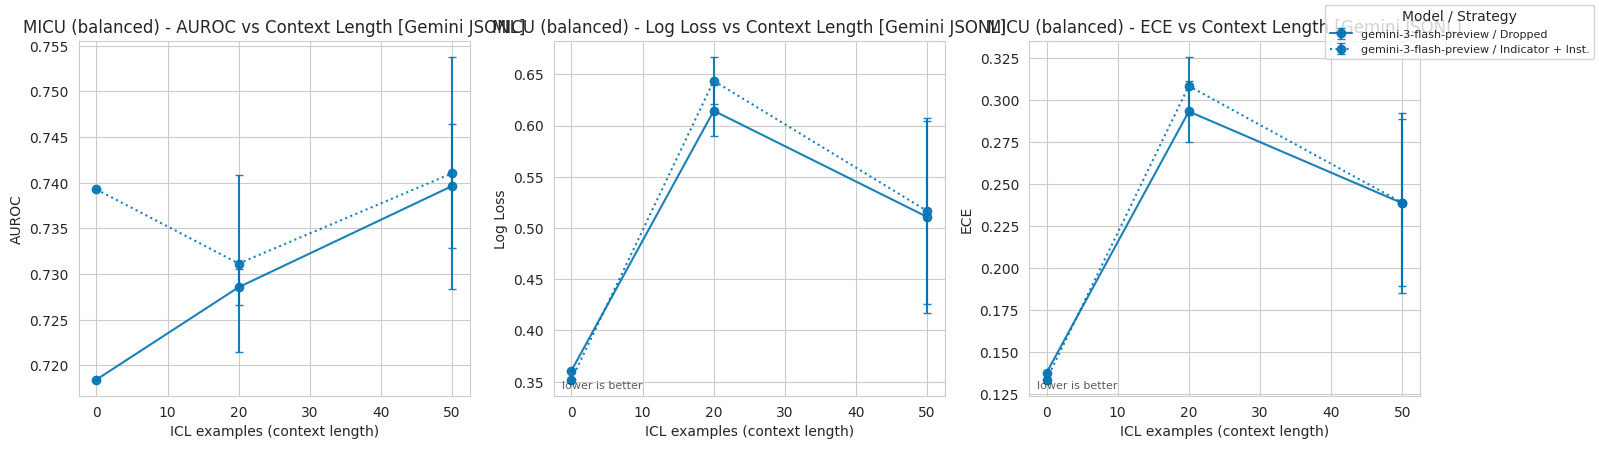

Saved: /home/yk3043@mc.cumc.columbia.edu/EHR-missingness/plots/mortality_csv_context_vs_serialization_by_cohort_balanced_gemini_jsonl.pdf


In [10]:
# Load Gemini batch-result JSONLs, extract prediction probabilities, and plot like the cohort block above.
import json
from collections import defaultdict, deque


def parse_icl_results_jsonl_filename(path: Path, task: str):
    """Parse metadata from ..._results.jsonl by reusing parse_icl_filename."""
    name = path.name
    if not name.endswith("_results.jsonl"):
        return None
    fake_pkl_name = name.replace("_results.jsonl", ".pkl")
    return parse_icl_filename(Path(fake_pkl_name), task)


def extract_text_from_vertex_batch_result_row(row_obj):
    response = row_obj.get("response", {}) if isinstance(row_obj, dict) else {}
    candidates = response.get("candidates", []) if isinstance(response, dict) else []
    if not candidates:
        return ""
    content = candidates[0].get("content", {}) if isinstance(candidates[0], dict) else {}
    parts = content.get("parts", []) if isinstance(content, dict) else []
    text_chunks = [p.get("text", "") for p in parts if isinstance(p, dict)]
    return "\n".join([t for t in text_chunks if t]).strip()


def extract_prompt_from_vertex_batch_result_row(row_obj):
    request = row_obj.get("request", {}) if isinstance(row_obj, dict) else {}
    contents = request.get("contents", []) if isinstance(request, dict) else []
    if not contents:
        return ""
    prompt_parts = []
    for content in contents:
        if not isinstance(content, dict):
            continue
        for part in content.get("parts", []):
            if isinstance(part, dict) and part.get("text"):
                prompt_parts.append(str(part.get("text")))
    return "\n".join(prompt_parts).strip()


def extract_target_patient_section(prompt_text):
    """Use only target patient section for alignment across different few-shot prefixes."""
    if not isinstance(prompt_text, str) or not prompt_text.strip():
        return ""
    marker = "\n### Patient\n"
    idx = prompt_text.find(marker)
    if idx == -1:
        marker = "### Patient\n"
        idx = prompt_text.find(marker)
    if idx == -1:
        # Fallback to full prompt if marker isn't present.
        return prompt_text.strip()
    return prompt_text[idx:].strip()


def extract_prediction_prob_from_text(output):
    """Notebook-local version of extract_prediction_sim (returns 0..1 float or None)."""
    if output is None:
        return None

    def _coerce_prediction(value):
        try:
            pred = float(value)
        except Exception:
            return None
        if 0.0 <= pred <= 1.0:
            return pred
        if 1.0 < pred <= 100.0:
            return pred / 100.0
        return None

    def _try_json(text):
        try:
            obj = json.loads(text)
        except Exception:
            return None
        if isinstance(obj, dict):
            if "prediction_prob" in obj:
                return _coerce_prediction(obj.get("prediction_prob"))
            if "prediction" in obj:
                return _coerce_prediction(obj.get("prediction"))
        if isinstance(obj, (int, float)):
            return _coerce_prediction(obj)
        return None

    fence_matches = re.findall(r"```(?:json)?\s*([\s\S]*?)\s*```", output, re.IGNORECASE)
    for block in fence_matches:
        pred = _try_json(block.strip())
        if pred is not None:
            return pred

    for match in re.findall(r"\{[\s\S]*?\}", output):
        pred = _try_json(match.strip())
        if pred is not None:
            return pred

    regex_match = re.search(r'"prediction_prob"\s*:\s*([0-9]+(?:\.[0-9]+)?)', output)
    if not regex_match:
        regex_match = re.search(r'"prediction"\s*:\s*([0-9]+(?:\.[0-9]+)?)', output)
    if regex_match:
        return _coerce_prediction(regex_match.group(1))

    return None


def load_label_map_from_reference_pkl(meta, predictions_dir: Path, task: str):
    """
    Build subject_id -> label map from any matching PKL run with same cohort/missingness settings.
    This avoids needing labels inside Vertex batch JSONL outputs.
    """
    cohort_tag = f"_cohort-{meta['cohort']}" if meta.get("cohort") else ""
    pattern = (
        f"predictions_{task}_*_{meta['explicit_missingness']}_{meta['labs_only']}_"
        f"{meta['include_cot_prompt']}_icl*{cohort_tag}_seed*.pkl"
    )
    candidates = sorted(predictions_dir.glob(pattern))
    for cand in candidates:
        obj = safe_load_pickle(cand)
        if not isinstance(obj, dict):
            continue
        label_map = {}
        for sid, payload in obj.items():
            if isinstance(payload, dict) and payload.get("label") is not None:
                label_map[str(sid)] = int(bool(payload.get("label")))
        if label_map:
            return label_map
    return None


def resolve_index_path_for_results(results_path: Path):
    """
    Try common index locations produced by exporter:
    1) same directory: <base>.index.json
    2) outputs/vertex_batch_inputs/<base>.index.json
    """
    base_name = results_path.name.replace("_results.jsonl", "")
    same_dir = results_path.with_name(f"{base_name}.index.json")
    if same_dir.exists():
        return same_dir

    alt_dir = PREDICTIONS_DIR / "vertex_batch_inputs" / f"{base_name}.index.json"
    if alt_dir.exists():
        return alt_dir

    return None


def resolve_input_jsonl_path_for_results(results_path: Path):
    """
    Try common input JSONL locations for a given results file.
    1) same directory: <base>.jsonl
    2) outputs/vertex_batch_inputs/<base>.jsonl
    """
    base_name = results_path.name.replace("_results.jsonl", "")
    same_dir = results_path.with_name(f"{base_name}.jsonl")
    if same_dir.exists():
        return same_dir

    alt_dir = PREDICTIONS_DIR / "vertex_batch_inputs" / f"{base_name}.jsonl"
    if alt_dir.exists():
        return alt_dir

    return None


rows_jsonl = []
jsonl_paths = sorted(PREDICTIONS_DIR.glob(f"predictions_{TASK}_*_icl*_seed*_results.jsonl"))

for path in jsonl_paths:
    meta = parse_icl_results_jsonl_filename(path, TASK)
    if meta is None:
        continue

    index_path = resolve_index_path_for_results(path)
    if index_path is None:
        print(f"[WARN] Missing index file for {path.name}; skipping")
        continue

    try:
        with open(index_path, "r", encoding="utf-8") as f:
            index_obj = json.load(f)
    except Exception as exc:
        print(f"[WARN] Failed to load index for {path.name}: {exc}")
        continue

    line_index = index_obj.get("line_index", []) if isinstance(index_obj, dict) else []
    if not isinstance(line_index, list) or len(line_index) == 0:
        print(f"[WARN] Empty/invalid line_index for {path.name}; skipping")
        continue

    label_map = load_label_map_from_reference_pkl(meta, PREDICTIONS_DIR, TASK)
    if not label_map:
        print(f"[WARN] Could not find label reference PKL for {path.name}; skipping")
        continue

    preds_by_subject = defaultdict(list)

    # Build line_idx -> subject_id map (normalized to string).
    line_to_subject = []
    for entry in line_index:
        sid = entry.get("subject_id") if isinstance(entry, dict) else None
        line_to_subject.append(None if sid is None else str(sid))

    # Robust alignment path: map output rows to subject IDs by target patient section,
    # because Vertex batch output row order may differ and few-shot prefix varies by seed.
    target_to_subject_queue = defaultdict(deque)
    input_jsonl_path = resolve_input_jsonl_path_for_results(path)
    if input_jsonl_path is not None:
        try:
            with open(input_jsonl_path, "r", encoding="utf-8") as fin:
                for idx, input_line in enumerate(fin):
                    if idx >= len(line_to_subject):
                        break
                    sid = line_to_subject[idx]
                    if sid is None:
                        continue
                    input_line = input_line.strip()
                    if not input_line:
                        continue
                    try:
                        input_obj = json.loads(input_line)
                    except Exception:
                        continue
                    req = input_obj.get("request", {}) if isinstance(input_obj, dict) else {}
                    contents = req.get("contents", []) if isinstance(req, dict) else []
                    prompt_parts = []
                    for content in contents:
                        if not isinstance(content, dict):
                            continue
                        for part in content.get("parts", []):
                            if isinstance(part, dict) and part.get("text"):
                                prompt_parts.append(str(part.get("text")))
                    prompt_text = "\n".join(prompt_parts).strip()
                    target_key = extract_target_patient_section(prompt_text)
                    if target_key:
                        target_to_subject_queue[target_key].append(sid)
        except Exception as exc:
            print(f"[WARN] Failed reading input jsonl for alignment ({path.name}): {exc}")

    try:
        matched_by_target = 0
        matched_by_line_fallback = 0
        with open(path, "r", encoding="utf-8") as f:
            for line_idx, line in enumerate(f):
                line = line.strip()
                if not line:
                    continue

                try:
                    row_obj = json.loads(line)
                except Exception:
                    continue

                sid = None
                result_prompt = extract_prompt_from_vertex_batch_result_row(row_obj)
                result_target_key = extract_target_patient_section(result_prompt)
                if result_target_key and result_target_key in target_to_subject_queue:
                    q = target_to_subject_queue[result_target_key]
                    if len(q) > 0:
                        sid = q.popleft()
                        matched_by_target += 1

                # Fallback to line-order alignment when target-based alignment is unavailable.
                if sid is None and line_idx < len(line_to_subject):
                    sid = line_to_subject[line_idx]
                    if sid is not None:
                        matched_by_line_fallback += 1

                if sid is None:
                    continue

                response_text = extract_text_from_vertex_batch_result_row(row_obj)
                pred = extract_prediction_prob_from_text(response_text)
                if is_prob(pred):
                    preds_by_subject[str(sid)].append(float(pred))
    except Exception as exc:
        print(f"[WARN] Failed reading {path.name}: {exc}")
        continue

    y_true = []
    y_prob = []
    for sid, pred_list in preds_by_subject.items():
        if len(pred_list) == 0:
            continue
        sid_str = str(sid)
        if sid_str not in label_map:
            continue
        y_true.append(int(label_map[sid_str]))
        y_prob.append(float(np.mean(pred_list)))

    if len(y_true) == 0:
        print(f"[WARN] No valid predictions with labels for {path.name}")
        continue

    print(
        f"[INFO] {path.name}: matched_subjects={len(y_true)}, "
        f"match_target={matched_by_target}, match_fallback={matched_by_line_fallback}, "
        f"mean_prob={float(np.mean(y_prob)):.3f}, prevalence={float(np.mean(y_true)):.3f}"
    )

    metrics = compute_binary_metrics(y_true, y_prob)
    rows_jsonl.append({
        **meta,
        **metrics,
        "serialization_strategy": strategy_label(
            meta["explicit_missingness"],
            meta["include_cot_prompt"],
        ),
        "source_format": "vertex_batch_results_jsonl",
        "path": path,
    })

results_df_gemini_jsonl = pd.DataFrame(rows_jsonl)
if results_df_gemini_jsonl.empty:
    raise RuntimeError("No Gemini batch-result JSONLs could be evaluated. Check *_results.jsonl and *.index.json files.")

print(f"Loaded {len(results_df_gemini_jsonl)} Gemini JSONL runs")
display(results_df_gemini_jsonl.head(20))

# ---- Plot with same style/logic as cohort block above ----
cohort_order = ["micu"]
selected_icl_sampling = ["balanced"]
include_zero_shot_baseline = True

plot_df = results_df_gemini_jsonl.copy()
plot_df["icl_sampling_strategy"] = plot_df["icl_sampling_strategy"].astype(str).str.lower()
selected_icl_sampling = [s.lower() for s in selected_icl_sampling]

if "cohort" in plot_df.columns:
    plot_df["cohort_for_plot"] = plot_df["cohort"].astype(str).str.lower()
elif "task" in plot_df.columns:
    plot_df["cohort_for_plot"] = (
        plot_df["task"].astype(str).str.extract(r"(ccu|micu)", expand=False).str.lower()
    )
elif "path" in plot_df.columns:
    plot_df["cohort_for_plot"] = (
        plot_df["path"].astype(str).str.extract(r"(?:^|[^a-zA-Z])(ccu|micu)(?:[^a-zA-Z]|$)", expand=False).str.lower()
    )
else:
    plot_df["cohort_for_plot"] = np.nan

plot_df = plot_df[plot_df["cohort_for_plot"].isin(cohort_order)].copy()

icl_df = plot_df[
    (plot_df["icl_num_examples"] > 0)
    & (plot_df["icl_sampling_strategy"].isin(selected_icl_sampling))
].copy()

if include_zero_shot_baseline:
    zero_shot_df = plot_df[
        (plot_df["icl_num_examples"] == 0)
        & (plot_df["icl_sampling_strategy"] == "none")
    ].copy()
    if not zero_shot_df.empty:
        zero_shot_panel_rows = []
        for sample_strategy in selected_icl_sampling:
            z = zero_shot_df.copy()
            z["icl_sampling_strategy"] = sample_strategy
            zero_shot_panel_rows.append(z)
        icl_df = pd.concat([icl_df] + zero_shot_panel_rows, ignore_index=True)

plot_df = icl_df.copy()
plot_df["serialization_strategy"] = pd.Categorical(
    plot_df["serialization_strategy"],
    categories=strategy_order,
    ordered=True,
)

model_order_jsonl = sorted(plot_df["model"].dropna().unique())
if len(model_order_jsonl) == 0:
    raise RuntimeError("No models available to plot after JSONL filtering.")

model_palette_jsonl = sns.color_palette("colorblind", n_colors=len(model_order_jsonl))
model_color_dict_jsonl = dict(zip(model_order_jsonl, model_palette_jsonl))
plot_df["model"] = pd.Categorical(plot_df["model"], categories=model_order_jsonl, ordered=True)

if plot_df.empty:
    print("No cohort rows found after JSONL ICL sampling strategy filter.")
else:
    sampling_to_plot = [
        s for s in selected_icl_sampling
        if s in set(plot_df["icl_sampling_strategy"].astype(str).str.lower())
    ]
    if not sampling_to_plot:
        raise RuntimeError("No matching ICL sampling strategies found in JSONL cohort-filtered data.")

    metrics = [("auroc", "AUROC", False), ("log_loss", "Log Loss", True), ("ece", "ECE", True)]
    n_rows = len(cohort_order) * len(sampling_to_plot)
    fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4.5 * n_rows), sharex=True)

    if n_rows == 1:
        axes = np.array([axes])

    row_ptr = 0
    for cohort in cohort_order:
        cohort_df = plot_df[plot_df["cohort_for_plot"] == cohort]

        for sample_strategy in sampling_to_plot:
            panel_df = cohort_df[cohort_df["icl_sampling_strategy"] == sample_strategy]

            for col_idx, (metric_col, title, lower_is_better) in enumerate(metrics):
                ax = axes[row_ptr, col_idx]

                for model in model_order_jsonl:
                    for strategy in strategy_order:
                        data = panel_df[
                            (panel_df["model"] == model)
                            & (panel_df["serialization_strategy"] == strategy)
                        ]
                        if data.empty:
                            continue

                        means = data.groupby("icl_num_examples", as_index=False)[metric_col].mean()
                        stds = data.groupby("icl_num_examples", as_index=False)[metric_col].std()
                        x = means["icl_num_examples"]
                        y = means[metric_col]
                        yerr = stds[metric_col].fillna(0.0)
                        if len(x) == 0:
                            continue

                        ax.errorbar(
                            x,
                            y,
                            yerr=yerr,
                            label=f"{model} / {strategy}",
                            color=model_color_dict_jsonl[model],
                            linestyle=strategy_linestyles[strategy],
                            marker="o",
                            capsize=3,
                            alpha=0.9,
                        )

                ax.set_title(f"{cohort.upper()} ({sample_strategy}) - {title} vs Context Length [Gemini JSONL]")
                ax.set_xlabel("ICL examples (context length)")
                ax.set_ylabel(title)
                if lower_is_better:
                    ax.text(0.02, 0.02, "lower is better", transform=ax.transAxes, fontsize=8, alpha=0.75)

            row_ptr += 1

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=8, title="Model / Strategy", loc="upper right")
    plt.tight_layout(rect=(0, 0, 0.9, 1))

    sampling_tag = "-".join(sampling_to_plot)
    save_path = PLOTS_DIR / f"mortality_csv_context_vs_serialization_by_cohort_{sampling_tag}_gemini_jsonl.pdf"
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print("Saved:", save_path)



In [11]:
# Visualize one patient's predictions across multiple samples and seeds (Gemini JSONL)
from IPython.display import Markdown, display

selected_model = "gemini-3-flash"   # substring or None
selected_icl_num = 20                # 0 / 20 / 50 / None
selected_strategy = "Indicator + Inst."             # Dropped / Indicator / Indicator + Inst. / None
selected_icl_sampling = "Balanced"  # random / stratified / balanced / none / None
selected_subject_id = None           # set explicit subject id (string/int), or keep None to auto-pick

max_seeds_to_show = 5
max_samples_per_seed = None          # e.g., 5; None = all available
max_response_chars = 2500

required_helpers = [
    "parse_icl_results_jsonl_filename",
    "resolve_index_path_for_results",
    "resolve_input_jsonl_path_for_results",
    "extract_prompt_from_vertex_batch_result_row",
    "extract_target_patient_section",
    "extract_text_from_vertex_batch_result_row",
    "extract_prediction_prob_from_text",
]
missing_helpers = [h for h in required_helpers if h not in globals()]
if missing_helpers:
    raise RuntimeError(
        "Run the Gemini JSONL metrics cell first. Missing helpers: " + ", ".join(missing_helpers)
    )

# Collect runs and metadata first.
run_infos = []
for path in sorted(PREDICTIONS_DIR.glob(f"predictions_{TASK}_*_icl*_seed*_results.jsonl")):
    meta = parse_icl_results_jsonl_filename(path, TASK)
    if meta is None:
        continue

    if selected_model is not None and selected_model not in str(meta.get("model", "")):
        continue
    if selected_icl_num is not None and int(meta.get("icl_num_examples", -1)) != int(selected_icl_num):
        continue
    if selected_icl_sampling is not None and str(meta.get("icl_sampling_strategy", "none")).lower() != str(selected_icl_sampling).lower():
        continue

    strategy = strategy_label(meta["explicit_missingness"], meta["include_cot_prompt"])
    if selected_strategy is not None and strategy != selected_strategy:
        continue

    run_infos.append((path, meta))

if not run_infos:
    raise RuntimeError("No matching Gemini JSONL runs found for selected filters.")

# Build subject set intersection across seeds to ensure comparability.
seed_to_subjects = {}
for path, meta in run_infos:
    index_path = resolve_index_path_for_results(path)
    if index_path is None:
        continue
    try:
        with open(index_path, "r", encoding="utf-8") as f:
            index_obj = json.load(f)
    except Exception:
        continue

    line_index = index_obj.get("line_index", []) if isinstance(index_obj, dict) else []
    subjects = set()
    for entry in line_index:
        if isinstance(entry, dict) and entry.get("subject_id") is not None:
            subjects.add(str(entry.get("subject_id")))
    seed_to_subjects[int(meta.get("seed", -1))] = subjects

if not seed_to_subjects:
    raise RuntimeError("Could not load subject IDs from index files.")

common_subjects = None
for sset in seed_to_subjects.values():
    common_subjects = set(sset) if common_subjects is None else (common_subjects & sset)

if selected_subject_id is None:
    if not common_subjects:
        raise RuntimeError("No common subject IDs across selected seeds. Set selected_subject_id manually.")
    selected_subject_id = sorted(common_subjects)[0]
else:
    selected_subject_id = str(selected_subject_id)

# Gather per-seed, per-sample predictions/responses for this subject.
rows = []
for path, meta in sorted(run_infos, key=lambda x: int(x[1].get("seed", -1))):
    seed = int(meta.get("seed", -1))

    index_path = resolve_index_path_for_results(path)
    input_jsonl_path = resolve_input_jsonl_path_for_results(path)
    if index_path is None or input_jsonl_path is None:
        continue

    try:
        with open(index_path, "r", encoding="utf-8") as f:
            index_obj = json.load(f)
    except Exception:
        continue

    line_index = index_obj.get("line_index", []) if isinstance(index_obj, dict) else []
    line_to_subject = [
        (None if not isinstance(e, dict) or e.get("subject_id") is None else str(e.get("subject_id")))
        for e in line_index
    ]

    # input target-section -> queue(subject_id, sample_idx)
    target_to_subject_sample = defaultdict(deque)
    try:
        with open(input_jsonl_path, "r", encoding="utf-8") as fin:
            for idx, line in enumerate(fin):
                if idx >= len(line_to_subject):
                    break
                sid = line_to_subject[idx]
                if sid is None:
                    continue
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                except Exception:
                    continue

                req = obj.get("request", {}) if isinstance(obj, dict) else {}
                contents = req.get("contents", []) if isinstance(req, dict) else []
                prompt_parts = []
                for c in contents:
                    if not isinstance(c, dict):
                        continue
                    for p in c.get("parts", []):
                        if isinstance(p, dict) and p.get("text"):
                            prompt_parts.append(str(p.get("text")))
                prompt_text = "\n".join(prompt_parts).strip()
                target_key = extract_target_patient_section(prompt_text)

                sample_idx = None
                if isinstance(line_index[idx], dict):
                    sample_idx = line_index[idx].get("sample_idx")
                try:
                    sample_idx = int(sample_idx)
                except Exception:
                    sample_idx = idx

                if target_key:
                    target_to_subject_sample[target_key].append((sid, sample_idx))
    except Exception:
        continue

    try:
        with open(path, "r", encoding="utf-8") as fout:
            for out_line_idx, line in enumerate(fout):
                line = line.strip()
                if not line:
                    continue
                try:
                    row_obj = json.loads(line)
                except Exception:
                    continue

                result_prompt = extract_prompt_from_vertex_batch_result_row(row_obj)
                target_key = extract_target_patient_section(result_prompt)
                mapped_sid = None
                mapped_sample_idx = None

                if target_key in target_to_subject_sample and len(target_to_subject_sample[target_key]) > 0:
                    mapped_sid, mapped_sample_idx = target_to_subject_sample[target_key].popleft()

                if mapped_sid is None and out_line_idx < len(line_to_subject):
                    mapped_sid = line_to_subject[out_line_idx]
                    mapped_sample_idx = out_line_idx

                if mapped_sid is None or str(mapped_sid) != selected_subject_id:
                    continue

                response_text = extract_text_from_vertex_batch_result_row(row_obj)
                pred_prob = extract_prediction_prob_from_text(response_text)
                rows.append({
                    "seed": seed,
                    "sample_idx": mapped_sample_idx,
                    "prediction_prob": pred_prob,
                    "response": response_text,
                    "file": path.name,
                })
    except Exception:
        continue

if not rows:
    raise RuntimeError(f"No rows found for subject_id={selected_subject_id} under selected filters.")

subject_df = pd.DataFrame(rows).sort_values(["seed", "sample_idx"]).reset_index(drop=True)
seeds_available = subject_df["seed"].dropna().unique().tolist()
seeds_to_show = sorted(seeds_available)[:max_seeds_to_show]
subject_df = subject_df[subject_df["seed"].isin(seeds_to_show)].copy()
if max_samples_per_seed is not None:
    subject_df = subject_df.groupby("seed", as_index=False, group_keys=False).head(max_samples_per_seed)

summary_df = (
    subject_df
    .groupby("seed", as_index=False)
    .agg(
        n_samples=("prediction_prob", "count"),
        pred_mean=("prediction_prob", "mean"),
        pred_std=("prediction_prob", "std"),
    )
    .sort_values("seed")
)

display(
    Markdown(
        f"## Patient-level multi-seed sample view  \n"
        f"- subject_id: `{selected_subject_id}`  \n"
        f"- model filter: `{selected_model}` | icl_num: `{selected_icl_num}` | "
        f"icl_sampling: `{selected_icl_sampling}` | strategy: `{selected_strategy}`"
    )
)

display(summary_df)

for seed in sorted(subject_df["seed"].unique()):
    seed_df = subject_df[subject_df["seed"] == seed].sort_values("sample_idx")
    display(Markdown(f"### Seed `{seed}`"))
    for _, r in seed_df.iterrows():
        display(
            Markdown(
                f"- sample_idx=`{r['sample_idx']}` | pred_prob=`{r['prediction_prob']}` | file=`{r['file']}`"
            )
        )
        print((r["response"] or "")[:max_response_chars])
        print("\n" + "-" * 100 + "\n")

## Patient-level multi-seed sample view  
- subject_id: `20050595`  
- model filter: `gemini-3-flash` | icl_num: `20` | icl_sampling: `Balanced` | strategy: `Indicator + Inst.`

,seed,n_samples,pred_mean,pred_std
0,1,3,0.640000,0.185203
1,2,3,0.540000,0.105830
2,3,3,0.773333,0.050332


### Seed `1`

- sample_idx=`0` | pred_prob=`0.65` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed1_results.jsonl`

The patient is a 42.9-year-old female admitted to the MICU with several critical physiological derangements. 

### 1. CLINICAL ASSESSMENT
The most striking findings are the renal and respiratory values. The serum creatinine is extremely elevated at 17.00 mg/dL, and the BUN is 87.00 mg/dL. This indicates either severe acute kidney injury (AKI) or, more likely given the normal lactate and bicarbonate levels, end-stage renal disease (ESRD). While a creatinine of 17.0 is critical, ESRD patients can sometimes be physiologically stable despite these numbers. 

The respiratory status is also highly concerning, with an arterial O2 pressure (PaO2) of 38.00 mmHg, indicating severe hypoxemia. Interestingly, the pulse oximetry (SpO2) is 100%, which suggests the patient is receiving significant supplemental oxygen or that there is a temporal discrepancy in measurements. 

On the positive side, the patient is relatively young (42.9), has a normal serum lactate (0.80), normal bicarbonate (23.00), sta

- sample_idx=`1` | pred_prob=`0.82` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed1_results.jsonl`

### Clinical Assessment
The patient is a 42.9-year-old female presenting with extreme laboratory abnormalities. Most notably, the **Serum Creatinine (17.00 mg/dL)** and **BUN (87.00 mg/dL)** indicate profound renal failure, likely requiring emergent dialysis. While the patient is relatively young, this level of renal dysfunction is critically high. Furthermore, the **Arterial O2 Pressure (PaO2) of 38.00 mmHg** indicates severe hypoxemia (normal is 75–100 mmHg). Although the **Pulse Oximetry (SpO2) is 100%**, the discrepancy suggests either a high level of supplemental oxygen/ventilatory support or a potential measurement discrepancy; however, in a clinical risk context, a PaO2 of 38 is life-threatening. The **Arterial pH (7.33)** shows a mild acidosis, but the **Serum Lactate (0.80)** is remarkably normal, suggesting that despite the organ failure, global tissue perfusion is currently maintained. The **Mean Blood Pressure (94.00)** and **Heart Rate (98.00)** are relatively stable, whic

- sample_idx=`2` | pred_prob=`0.45` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed1_results.jsonl`

1. CLINICAL ASSESSMENT:
The patient is a 42.9-year-old female presenting with several critical laboratory abnormalities. The most striking finding is the profound renal impairment, with a Serum Creatinine of 17.0 mg/dL and a BUN of 87.0 mg/dL. A creatinine level of 17.0 is extremely high and indicates either severe acute kidney injury (potentially from rhabdomyolysis or toxic insult) or end-stage renal disease (ESRD) with missed dialysis. Additionally, the patient has severe arterial hypoxemia with a PaO2 of 38.0 mmHg. Although the SpO2 is 100%, this suggests the patient is likely receiving significant supplemental oxygen or mechanical ventilation, yet the underlying gas exchange is severely impaired.

On the positive side, the patient is relatively young (42.9 years), and the serum lactate is normal (0.80 mmol/L). A normal lactate in the presence of such severe renal and respiratory markers suggests that, at the moment of measurement, tissue perfusion and anaerobic metabolism are not 

### Seed `2`

- sample_idx=`0` | pred_prob=`0.42` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed2_results.jsonl`

### Clinical Assessment
The patient is a 42.9-year-old female presenting with extreme physiologic derangements in both renal and respiratory systems. 
- **Renal Function:** The Serum Creatinine of 17.00 mg/dL and BUN of 87.00 mg/dL indicate profound renal failure. This level of creatinine is significantly higher than seen in most acute ICU cases and suggests either advanced end-stage renal disease (ESRD) or severe acute kidney injury requiring immediate renal replacement therapy.
- **Respiratory Status:** The Arterial O2 Pressure (PaO2) of 38.00 mmHg is critically low, indicating severe hypoxemia (normal is typically >75-80 mmHg). While the SpO2 is recorded at 100.00%, this massive discrepancy suggests either the PaO2 was measured during a period of acute decompensation (e.g., prior to intubation) or the SpO2 is misleading due to supplemental oxygen/mechanical ventilation. The PaCO2 (47.00) and pH (7.33) indicate a mild respiratory acidosis.
- **Hemodynamics and Perfusion:** A signific

- sample_idx=`1` | pred_prob=`0.62` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed2_results.jsonl`

1. CLINICAL ASSESSMENT:
The patient presents with several critical physiological derangements. The most striking is the severe renal impairment, evidenced by a Serum Creatinine of 17.00 mg/dL and a BUN of 87.00 mg/dL. A creatinine level of 17.0 is extremely high and indicates either profound acute kidney injury (AKI) or end-stage renal disease (ESRD) with a significant acute-on-chronic component requiring urgent intervention. 

Additionally, the Arterial O2 Pressure (PaO2) is critically low at 38.00 mmHg, indicating severe hypoxemia. While the Pulse Oximetry (SpO2) is recorded at 100%, such a profound discordance between SpO2 and PaO2 often occurs in the context of rapid clinical changes, measurement timing differences, or supplemental oxygen administration that has not yet reflected in arterial tension. A PaO2 of 38 mmHg is typically associated with respiratory failure. 

On the protective side, the patient is relatively young (42.9 years) and has a normal Serum Lactate (0.80), normal

- sample_idx=`2` | pred_prob=`0.58` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed2_results.jsonl`

Based on a step-by-step analysis of the patient record:

1.  **CLINICAL ASSESSMENT:**
    The patient presents a highly complex and somewhat contradictory clinical picture. The most striking abnormalities are the renal and respiratory markers. A Serum Creatinine of 17.0 mg/dL and BUN of 87.0 mg/dL indicate profound renal failure, likely either severe acute kidney injury or end-stage renal disease. Furthermore, the Arterial O2 Pressure (PaO2) of 38.0 mmHg is critically low (severe hypoxemia), which would typically be life-threatening.
    However, there are significant mitigating factors: the patient is relatively young (42.9 years), has a normal Serum Lactate (0.80), and maintainable hemodynamic stability (MBP 94.0, HR 98.0). The Pulse Oximetry (SpO2) of 100% also sharply contradicts the PaO2 of 38.0, suggesting either the PaO2 was measured prior to significant oxygen supplementation/ventilation or there is a measurement artifact. The mild acidosis (pH 7.33) despite the renal and respi

### Seed `3`

- sample_idx=`0` | pred_prob=`0.78` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed3_results.jsonl`

1. CLINICAL ASSESSMENT:
The patient is a 42.9-year-old female presenting with critical multi-organ dysfunction. The most striking abnormality is the extreme renal failure, with a Serum Creatinine of 17.00 mg/dL and a BUN of 87.00 mg/dL. While a creatinine of 17.00 might suggest a chronic condition (as acute rises to this level are rare before intervention), it represents a state of severe metabolic derangement.

Furthermore, the respiratory status is highly concerning. The Arterial O2 Pressure (PaO2) of 38.00 mmHg is critically low (severe hypoxemia), and the PaCO2 of 47.00 mmHg combined with a pH of 7.33 indicates a respiratory acidosis. There is a significant discrepancy between the SpO2 (100%) and the PaO2 (38 mmHg); if the PaO2 is accurate, the patient is in a state of profound respiratory failure. 

On the positive side, the Serum Lactate is normal (0.80), and the mean blood pressure (mbp 94.00) and heart rate (98.00) are stable, suggesting that despite the biochemical and respira

- sample_idx=`1` | pred_prob=`0.82` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed3_results.jsonl`

The clinical assessment of this 42.9-year-old female patient reveals several critical physiological derangements. Most notably, the renal markers are extremely abnormal, with a Serum Creatinine of 17.00 mg/dL and a BUN of 87.00 mg/dL. While such a high creatinine often suggests chronic end-stage renal disease (ESRD), it represents a significant metabolic burden and risk factor in an acute ICU setting. Furthermore, the Arterial O2 Pressure (PaO2) of 38.00 mmHg indicates severe hypoxemia, which is life-threatening. Although the Pulse Oximetry (SpO2) is recorded at 100%, the discrepancy with the PaO2 is clinically concerning and often suggests either measurement error or severe ventilation-perfusion mismatch. The patient also exhibits mild acidosis (pH 7.33) and hypercapnia (PaCO2 47.00), suggesting respiratory distress or compensation for metabolic issues.

The missingness mechanism analysis suggests a high-acuity patient. The clinical team has prioritized Arterial Blood Gases (ABGs), La

- sample_idx=`2` | pred_prob=`0.72` | file=`predictions_mortality_csv_gemini-3-flash-preview_True_True_True_icl20_balanced_cohort-micu_seed3_results.jsonl`

1. CLINICAL ASSESSMENT:
The patient is a 42.9-year-old female presenting with extreme physiological derangements. The most striking findings are the renal and respiratory markers. A Serum Creatinine of 17.0 mg/dL and BUN of 87.0 mg/dL indicate profound renal failure (likely either severe acute kidney injury or poorly managed end-stage renal disease). Furthermore, the Arterial O2 Pressure (PaO2) of 38.0 mmHg is critically low, signifying severe hypoxemia (normal is 75-100 mmHg), which is life-threatening. 

There is a notable physiological discrepancy between the PaO2 (38.0) and the Pulse Oximetry (SpO2 100.0%). This mismatch often suggests either a measurement error, the use of supplemental oxygen that has not yet reflected in arterial tension, or a state where hemoglobin is saturated but arterial oxygen tension remains dangerously low. Despite these critical values, the Serum Lactate is normal (0.80), and the patient is relatively young (42.9), which are significant protective factors

In [8]:
# Show sample reasoning/output traces split by cohort (MICU and CCU)
from IPython.display import Markdown, display

selected_model = "Qwen3-14B"          # substring match in filename model id; set to None for all
selected_icl_num = 0                  # set to None for all
selected_strategy = "Indicator + Inst."  # one of: Dropped, Indicator, Indicator + Inst., or None
selected_seed = None                   # set to an int (e.g., 1) to filter seed
selected_cohorts = ["ccu"]     # cohorts to display

examples_per_cohort = 3
max_chars = 8000

all_paths = sorted(PREDICTIONS_DIR.glob(f"predictions_{TASK}_*_icl*_seed*.pkl"))

for cohort_name in selected_cohorts:
    shown = 0
    display(Markdown(f"## Cohort: `{cohort_name.upper()}`"))

    for path in all_paths:
        meta = parse_icl_filename(path, TASK)
        if meta is None:
            continue

        file_cohort = meta.get("cohort")
        if file_cohort is None or str(file_cohort).lower() != cohort_name:
            continue

        if selected_model is not None and selected_model not in meta["model"]:
            continue
        if selected_icl_num is not None and meta["icl_num_examples"] != selected_icl_num:
            continue
        if selected_seed is not None and meta["seed"] != selected_seed:
            continue

        strategy = strategy_label(meta["explicit_missingness"], meta["include_cot_prompt"])
        if selected_strategy is not None and strategy != selected_strategy:
            continue

        subject_dicts = safe_load_pickle(path)
        if not isinstance(subject_dicts, dict):
            continue

        for subject_id, sd in subject_dicts.items():
            if not isinstance(sd, dict):
                continue

            response = sd.get("response")
            if not response:
                continue

            label = sd.get("label")
            pred = sd.get("prediction")

            display(
                Markdown(
                    f"### `{path.name}` | subject_id=`{subject_id}`  \n"
                    f"- cohort: `{cohort_name}` | model: `{meta['model']}` | strategy: `{strategy}` | icl: `{meta['icl_num_examples']}` | seed: `{meta['seed']}`  \n"
                    f"- label: `{label}` | prediction: `{pred}`"
                )
            )
            print(response[:max_chars])
            print("\n" + "-" * 100 + "\n")

            shown += 1
            if shown >= examples_per_cohort:
                break

        if shown >= examples_per_cohort:
            break

    if shown == 0:
        print(f"No responses found for cohort={cohort_name} with current filters.")

## Cohort: `CCU`

### `predictions_mortality_csv_Qwen3-14B_True_True_True_icl0_baseline_cohort-ccu_seed1.pkl` | subject_id=`21200943`  
- cohort: `ccu` | model: `Qwen3-14B` | strategy: `Indicator + Inst.` | icl: `0` | seed: `1`  
- label: `0` | prediction: `0.18`

### 1. CLINICAL ASSESSMENT

The patient is a 67.9-year-old female admitted to the Coronary Care Unit (CCU), and the clinical data from the first 48 hours of the stay are reviewed for mortality risk estimation.

#### Demographics
- **Age**: 67.9 years – This is an advanced age, and age is a well-known risk factor for mortality in CCU patients. Older patients have higher baseline risks due to comorbidities and physiological decline.
- **Gender**: Female – While gender alone is not a strong direct predictor of mortality in CCU, it is known that females may have a slightly higher mortality risk in certain cardiac conditions.

#### Laboratory Values
- **Serum Bicarbonate (HCO3)**: 30.00 mEq/L – Elevated bicarbonate suggests metabolic alkalosis, which can be associated with volume depletion or diuretic use. It may reflect a compensatory mechanism for underlying conditions, but it is not directly a strong mortality risk.
- **Blood Urea Nitrogen (BUN)**: 51.00 mg/dL – This is significantly ele

### `predictions_mortality_csv_Qwen3-14B_True_True_True_icl0_baseline_cohort-ccu_seed1.pkl` | subject_id=`28508247`  
- cohort: `ccu` | model: `Qwen3-14B` | strategy: `Indicator + Inst.` | icl: `0` | seed: `1`  
- label: `0` | prediction: `0.23`

### 1. CLINICAL ASSESSMENT

#### **Demographics**
- **Age**: 85.7 years – Advanced age is a well-established risk factor for in-hospital mortality, particularly in the CCU setting. Age >80 is associated with increased mortality due to comorbidities, frailty, and decreased physiological reserve.

- **Gender**: Male – While gender alone is not a strong predictor, men may be more likely to present with more severe coronary artery disease, and this could influence outcomes. However, the impact is generally small compared to other factors.

#### **Laboratory Values**
- **Serum Bicarbonate (HCO3)**: 21.00 mmol/L – Normal range is 22–28 mmol/L. Mildly low. This could be indicative of early metabolic acidosis or compensation for respiratory alkalosis, though not severe.
  
- **Blood Urea Nitrogen (BUN)**: 29.00 mg/dL – Elevated. Normal range is 7–20 mg/dL. Elevated BUN may suggest renal impairment or dehydration. Given that serum creatinine is 1.30 mg/dL (normal: 0.6–1.2 mg/dL), this suggests 

### `predictions_mortality_csv_Qwen3-14B_True_True_True_icl0_baseline_cohort-ccu_seed1.pkl` | subject_id=`20775001`  
- cohort: `ccu` | model: `Qwen3-14B` | strategy: `Indicator + Inst.` | icl: `0` | seed: `1`  
- label: `0` | prediction: `0.3`

### 1. CLINICAL ASSESSMENT:

The patient is an 80.8-year-old female admitted to the CCU. Age is a strong independent risk factor for in-CCU mortality, especially in patients over 75 years old. The patient’s age places her in a high-risk demographic group.

#### Laboratory Values:
- **Serum Bicarbonate (HCO3):** 19.00 mmol/L – Slightly low, which may suggest mild metabolic acidosis or compensation for other processes.
- **Blood Urea Nitrogen (BUN):** 43.00 mg/dL – Elevated. This is a marker of renal dysfunction and can indicate poor perfusion, dehydration, or acute kidney injury (AKI).
- **Serum Creatinine:** 2.00 mg/dL – Elevated, indicating significant renal impairment. This is a strong independent risk factor for in-hospital mortality.
- **Serum Glucose:** 98.00 mg/dL – Normal range, suggesting no acute hyperglycemia or hypoglycemia.
- **INR (Coagulation):** 1.00 – Within normal range.
- **Prothrombin Time (PT):** 12.40 seconds – Normal range.
- **Troponin T:** 0.02 ng/mL – Slightly 

In [ ]:
# Visualize a sample prompt as constructed in src/inference/generate_predictions_icl.py
from IPython.display import Markdown, display
import random

from src.inference.inference_utils import get_detailed_instruct_mortality_csv

# Match the same run settings style used above
selected_model = "Qwen3-8B"            # substring match in model id; None for any
selected_icl_num = 50                   # None for any
selected_strategy = "Indicator + Inst."  # Dropped / Indicator / Indicator + Inst. / None
selected_seed = None                    # e.g., 1; None for first matching
selected_cohort = "micu"               # micu / ccu / None

all_paths = sorted(PREDICTIONS_DIR.glob(f"predictions_{TASK}_*_icl*_seed*.pkl"))
chosen_path = None
chosen_meta = None

for path in all_paths:
    meta = parse_icl_filename(path, TASK)
    if meta is None:
        continue

    run_strategy = strategy_label(meta["explicit_missingness"], meta["include_cot_prompt"])

    if selected_model is not None and selected_model not in meta["model"]:
        continue
    if selected_icl_num is not None and meta["icl_num_examples"] != selected_icl_num:
        continue
    if selected_seed is not None and meta["seed"] != selected_seed:
        continue
    if selected_strategy is not None and run_strategy != selected_strategy:
        continue

    run_cohort = meta.get("cohort")
    if selected_cohort is not None and str(run_cohort).lower() != str(selected_cohort).lower():
        continue

    chosen_path = path
    chosen_meta = meta
    break

if chosen_path is None:
    print("No matching prediction run found for the selected filters.")
else:
    pred_subject_dicts = safe_load_pickle(chosen_path)
    if not isinstance(pred_subject_dicts, dict) or len(pred_subject_dicts) == 0:
        print(f"Could not load predictions from {chosen_path.name}")
    else:
        # pick one eval subject from the chosen predictions file
        sample_subject_id = next(iter(pred_subject_dicts.keys()))
        sample_item = pred_subject_dicts[sample_subject_id]
        target_serialization = sample_item.get("serialization", "")

        # Rebuild the subject_dict path used by generate_predictions_icl.py
        cohort_tag = ""
        if chosen_meta.get("cohort"):
            cohort_tag = f"_cohort-{chosen_meta['cohort']}"

        subject_dict_path = (
            ROOT
            / "data"
            / f"{TASK}_subject_dict_{chosen_meta['explicit_missingness']}_{chosen_meta['labs_only']}{cohort_tag}.pkl"
        )

        data_dicts = safe_load_pickle(subject_dict_path)
        if not isinstance(data_dicts, dict) or "train" not in data_dicts:
            print(f"Could not load training subject dicts from: {subject_dict_path}")
        else:
            # Mirror generate_predictions_icl.py behavior for ICL example sampling
            def _sample_stratified_ids(subject_dicts_train, num_examples, rng):
                label_map = {0: [], 1: []}
                for subject_id, payload in subject_dicts_train.items():
                    label = payload.get("label")
                    try:
                        label_int = int(label)
                    except Exception:
                        label_int = 1 if str(label).strip().lower() in ("true", "1", "yes") else 0
                    label_map[1 if label_int == 1 else 0].append(subject_id)

                total_ids = label_map[0] + label_map[1]
                if not total_ids:
                    return []

                k = min(num_examples, len(total_ids))
                if not label_map[0] or not label_map[1]:
                    return rng.sample(total_ids, k)

                prevalence = len(label_map[1]) / len(total_ids)
                k_pos = int(round(k * prevalence))
                k_neg = k - k_pos

                if k >= 2:
                    k_pos = max(1, k_pos)
                    k_neg = max(1, k - k_pos)
                    if k_pos + k_neg != k:
                        k_neg = k - k_pos

                k_pos = min(k_pos, len(label_map[1]))
                k_neg = min(k_neg, len(label_map[0]))

                sampled_pos = rng.sample(label_map[1], k_pos)
                sampled_neg = rng.sample(label_map[0], k_neg)
                sampled_ids = sampled_pos + sampled_neg

                if len(sampled_ids) < k:
                    remaining = [sid for sid in total_ids if sid not in sampled_ids]
                    sampled_ids += rng.sample(remaining, k - len(sampled_ids))

                rng.shuffle(sampled_ids)
                return sampled_ids

            def _format_icl_examples(subject_dicts_train, num_examples, rng, stratified=True, pool_size=None):
                subject_ids = list(subject_dicts_train.keys())
                if not subject_ids:
                    return ""

                if pool_size is None:
                    pool_size = num_examples

                if stratified:
                    sampled_ids = _sample_stratified_ids(subject_dicts_train, pool_size, rng)
                else:
                    k = min(pool_size, len(subject_ids))
                    sampled_ids = rng.sample(subject_ids, k)

                if num_examples < len(sampled_ids):
                    sampled_ids = sampled_ids[:num_examples]

                example_blocks = []
                for i, subject_id in enumerate(sampled_ids, start=1):
                    serialization = subject_dicts_train[subject_id]["serialization"]
                    label = subject_dicts_train[subject_id]["label"]
                    try:
                        label_bool = bool(int(label))
                    except Exception:
                        label_bool = str(label).strip().lower() in ("true", "1", "yes")

                    example_blocks.append(
                        "### Example {idx}\n{serialization}\nAnswer: {label}\n".format(
                            idx=i,
                            serialization=serialization,
                            label="True" if label_bool else "False",
                        )
                    )

                return "\n".join(example_blocks).strip()

            def _build_icl_prompt_sim(instruction, examples_block, target_serialization):
                prompt = instruction.strip()
                if examples_block:
                    prompt += "\n\nHere are some labeled examples from this hospital:\n"
                    prompt += examples_block
                    prompt += "\n\nNow output response for the next patient.\n"
                prompt += "\n### Patient\n"
                prompt += target_serialization
                prompt += "\n### Response:\n"
                return prompt

            cfg = {
                "task_query": "Estimate probability of in-hospital mortality.",
                "include_cot_prompt": bool(chosen_meta["include_cot_prompt"]),
                "icl_num_examples": int(chosen_meta["icl_num_examples"]),
                "mortality_cohort": chosen_meta.get("cohort") or "all",
            }

            rng = random.Random(chosen_meta["seed"])
            examples_block = _format_icl_examples(
                data_dicts["train"],
                num_examples=int(chosen_meta["icl_num_examples"]),
                rng=rng,
                stratified=True,
                pool_size=int(chosen_meta["icl_num_examples"]),
            )

            instruction = get_detailed_instruct_mortality_csv(cfg)
            if int(chosen_meta["icl_num_examples"]) == 0:
                sample_prompt = instruction + target_serialization
            else:
                sample_prompt = _build_icl_prompt_sim(instruction, examples_block, target_serialization)

            display(
                Markdown(
                    f"### Sample reconstructed prompt from `generate_predictions_icl.py`\n"
                    f"- file: `{chosen_path.name}`  \n"
                    f"- model: `{chosen_meta['model']}` | cohort: `{chosen_meta.get('cohort')}` | "
                    f"strategy: `{strategy_label(chosen_meta['explicit_missingness'], chosen_meta['include_cot_prompt'])}` | "
                    f"icl: `{chosen_meta['icl_num_examples']}` | seed: `{chosen_meta['seed']}`  \n"
                    f"- subject_id: `{sample_subject_id}`"
                )
            )

            print(sample_prompt)
            print("\n" + "-" * 100 + "\n")

            if examples_block:
                display(Markdown("#### ICL examples block used in this prompt"))
                print(examples_block)
                print("\n" + "-" * 100 + "\n")

/user/yk3043/.conda/envs/vllm_env/lib/python3.11/site-packages/polars/_cpu_check.py:258: RuntimeWarning: Missing required CPU features.

The following required CPU features were not detected:
    avx2, fma, bmi1, bmi2, lzcnt, movbe
Continuing to use this version of Polars on this processor will likely result in a crash.
Install the `polars-lts-cpu` package instead of `polars` to run Polars with better compatibility.

Hint: If you are on an Apple ARM machine (e.g. M1) this is likely due to running Python under Rosetta.
It is recommended to install a native version of Python that does not run under Rosetta x86-64 emulation.

If you believe this warning to be a false positive, you can set the `POLARS_SKIP_CPU_CHECK` environment variable to bypass this check.

  warnings.warn(


### Sample reconstructed prompt from `generate_predictions_icl.py`
- file: `predictions_mortality_csv_Qwen3-8B_True_True_True_icl50_cohort-micu_seed1.pkl`  
- model: `Qwen3-8B` | cohort: `micu` | strategy: `Indicator + Inst.` | icl: `50` | seed: `1`  
- subject_id: `20840530`

You are an expert Clinical Risk Estimation System analyzing a patient record from an emergent Medical ICU (MICU) admission. Your goal is to estimate the risk of in-hospital mortality based on data collected during the first 24 hours of the Medical ICU (MICU) stay.

Please provide your analysis step-by-step using the following structure:

1. CLINICAL ASSESSMENT: Analyze mortality risk based on the observed physiology (demographics, labs, vital signs etc.).
2. MISSINGNESS MECHANISM: Analyze WHY specific features are missing. Consider whether their absence is potentially informative of the outcome.
3. PATTERN RECOGNITION: Look at the few-shot examples provided from the hospital's Medical ICU (MICU). Identify any hospital-specific risk patterns and correlations using (a) observed values and (b) whether a feature is measured or not).

After your analysis, you must output the final probability in a strictly valid JSON block at the very end of your response. Use this format:
```json
{
  "pred

#### ICL examples block used in this prompt

### Example 1

 # Electronic Health Record
## Demographics
Patient age: 38.2
Patient gender: M
## Most Recent Measurements
- Serum Bicarbonate (HCO3)
  - 29.00
- Blood Urea Nitrogen (BUN)
  - 7.00
- Serum Creatinine
  - 0.60
- Serum Glucose
  - 207.00
- Arterial O2 Pressure (PaO2)
  - Not measured
- Arterial CO2 Pressure (PaCO2)
  - Not measured
- Arterial pH
  - Not measured
- Serum Lactate
  - Not measured
- Arterial O2 Saturation (SaO2)
  - Not measured
- INR (Coagulation)
  - 1.00
- Prothrombin Time (PT)
  - 10.70
- Fibrinogen
  - Not measured
- Troponin T
  - Not measured
- Heart Rate (BPM)
  - 100.96
- Mean Arterial Pressure (MAP)
  - 108.50
- Pulse Oximetry (SpO2)
  - 94.40

Answer: False

### Example 2

 # Electronic Health Record
## Demographics
Patient age: 98.0
Patient gender: F
## Most Recent Measurements
- Serum Bicarbonate (HCO3)
  - 20.00
- Blood Urea Nitrogen (BUN)
  - 92.00
- Serum Creatinine
  - 2.40
- Serum Glucose
  - 84.00
- Arterial O2 Pressure (PaO2)
  - Not meas

In [8]:
# Print sample generations from Sonnet 4.5 runs
# Uses parse_icl_filename(), safe_load_pickle(), PREDICTIONS_DIR, TASK defined above.
sonnet45_name_hints = [
    "sonnet-4.5",
    "sonnet-4-5",
    "claude-sonnet-4-5",
    "claude-sonnet-4-5-",
]

num_samples_per_file = 3
max_chars = 5000

all_paths = sorted(PREDICTIONS_DIR.glob(f"predictions_{TASK}_*_icl*.pkl"))
matched_paths = []

for path in all_paths:
    meta = parse_icl_filename(path, TASK)
    if meta is None:
        continue
    model_name = str(meta.get("model", "")).lower()
    if any(hint in model_name for hint in sonnet45_name_hints):
        matched_paths.append((path, meta))

if not matched_paths:
    print("No Sonnet 4.5 prediction files found in outputs/ yet.")
else:
    print(f"Found {len(matched_paths)} Sonnet 4.5 run(s).")
    for path, meta in matched_paths:
        pred_dict = safe_load_pickle(path)
        if not isinstance(pred_dict, dict) or len(pred_dict) == 0:
            print(f"Skipping empty/unreadable file: {path.name}")
            continue

        shown = 0
        print("\n" + "=" * 100)
        print(
            f"file={path.name} | model={meta['model']} | cohort={meta.get('cohort')} | "
            f"icl={meta['icl_num_examples']} | seed={meta['seed']}"
        )
        print("=" * 100)

        for subject_id, sd in pred_dict.items():
            if not isinstance(sd, dict):
                continue
            response = sd.get("response")
            if not response:
                continue

            label = sd.get("label")
            pred = sd.get("prediction")
            print(f"\n--- subject_id={subject_id} | label={label} | prediction={pred} ---")
            print(str(response)[:max_chars])

            shown += 1
            if shown >= num_samples_per_file:
                break

        if shown == 0:
            print("No responses found in this file.")

Found 3 Sonnet 4.5 run(s).

file=predictions_mortality_csv_sonnet-4.5_True_True_True_icl0_cohort-micu_seed1_test5.pkl | model=sonnet-4.5 | cohort=micu | icl=0 | seed=1

--- subject_id=20840530 | label=1 | prediction=0.12 ---
# Clinical Risk Analysis for MICU Admission

## 1. CLINICAL ASSESSMENT

### Demographics
- **Age: 57.9 years, Female** - Moderate age with some baseline mortality risk, though not in the highest-risk elderly category.

### Vital Signs - FAVORABLE
- **Heart Rate: 72.94 bpm** - Normal, stable cardiac rhythm
- **MAP: 73.16 mmHg** - Adequate (≥65 mmHg threshold met), suggesting reasonable perfusion
- **SpO2: 97.47%** - Excellent oxygenation on current support

### Acid-Base & Oxygenation - FAVORABLE
- **Arterial pH: 7.42** - Normal (7.35-7.45)
- **PaCO2: 42 mmHg** - Normal ventilation
- **PaO2: 87 mmHg** - Adequate oxygenation (though slightly below ideal >90)
- **HCO3: 26 mEq/L** - Normal bicarbonate
- **Lactate: 1.4 mmol/L** - Normal (<2), no significant tissue hypop